In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better readability
pd.set_option('display.max_columns', None)

In [2]:
# Load all datasets
daily_activity = pd.read_csv("../data/dailyActivity_merged.csv")
heartrate = pd.read_csv("../data/heartrate_seconds_merged.csv")
hourly_calories = pd.read_csv("../data/hourlyCalories_merged.csv")
hourly_intensities = pd.read_csv("../data/hourlyIntensities_merged.csv")
hourly_steps = pd.read_csv("../data/hourlySteps_merged.csv")
minute_calories = pd.read_csv("../data/minuteCaloriesNarrow_merged.csv")
minute_intensities = pd.read_csv("../data/minuteIntensitiesNarrow_merged.csv")
minute_mets = pd.read_csv("../data/minuteMETsNarrow_merged.csv")
minute_sleep = pd.read_csv("../data/minuteSleep_merged.csv")
minute_steps = pd.read_csv("../data/minuteStepsNarrow_merged.csv")
weight_log = pd.read_csv("../data/weightLogInfo_merged.csv")

# 🔁 Remove duplicates in minuteSleep_merged
print("Before removing duplicates:", minute_sleep.duplicated().sum())
minute_sleep_cleaned = minute_sleep.drop_duplicates()
print("After removing duplicates:", minute_sleep_cleaned.duplicated().sum())

# 🧩 Handle missing values in weightLogInfo_merged
# Check missing values
print("\nMissing values in weight_log:")
print(weight_log.isnull().sum())

# Since 'Fat' column has 31 missing out of 33 rows, it's nearly all missing.
# We'll drop the 'Fat' column entirely for now
weight_log_cleaned = weight_log.drop(columns=["Fat"])

# Verify changes
print("\nColumns in cleaned weight_log:")
print(weight_log_cleaned.columns)

Before removing duplicates: 525
After removing duplicates: 0

Missing values in weight_log:
Id                 0
Date               0
WeightKg           0
WeightPounds       0
Fat               31
BMI                0
IsManualReport     0
LogId              0
dtype: int64

Columns in cleaned weight_log:
Index(['Id', 'Date', 'WeightKg', 'WeightPounds', 'BMI', 'IsManualReport',
       'LogId'],
      dtype='object')


In [6]:
# View first few rows
daily_activity.head()
minute_sleep.head()

# Show column names
print(daily_activity.columns.tolist())
print(minute_sleep.columns.tolist())

['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']
['Id', 'date', 'value', 'logId']


In [5]:
# Number of unique participants
print("Unique users in daily_activity:", daily_activity['Id'].nunique())
print("Unique users in minute_sleep:", minute_sleep['Id'].nunique())

# Number of observations
print("Rows in daily_activity:", daily_activity.shape[0])
print("Rows in minute_sleep:", minute_sleep.shape[0])

# Quick summary of key activity variables
daily_activity[['TotalSteps', 'TotalDistance', 'SedentaryMinutes']].describe()

# Quick summary of key sleep variables
minute_sleep[['value', 'logId']].describe()


Unique users in daily_activity: 35
Unique users in minute_sleep: 23
Rows in daily_activity: 457
Rows in minute_sleep: 198559


,value,logId
count,198559.000000,1.985590e+05
mean,1.085899,1.124161e+10
std,0.314480,7.969858e+07
min,1.000000,1.110365e+10
25%,1.000000,1.116551e+10
50%,1.000000,1.124395e+10
75%,1.000000,1.131074e+10
max,3.000000,1.137488e+10


### Correlation between Total Steps and Sedentary Minutes

The scatterplot below reveals an inverse relationship: as total daily steps increase, sedentary minutes decrease. This trend aligns with expected user behavior and validates the quality of the data.

This finding supports the idea that higher activity leads to better health outcomes and could inform Bellabeat’s motivational messaging.


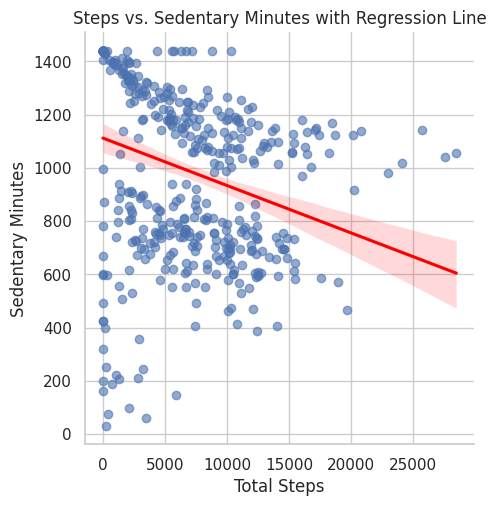

<Figure size 640x480 with 0 Axes>

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=daily_activity, 
    x="TotalSteps", 
    y="SedentaryMinutes", 
    scatter_kws={"alpha": 0.6}, 
    line_kws={"color": "red"}
)

plt.title("Steps vs. Sedentary Minutes with Regression Line")
plt.xlabel("Total Steps")
plt.ylabel("Sedentary Minutes")
plt.show()

plt.savefig("Steps vs. Sedentary Minutes with Regression Line.png", dpi=300, bbox_inches='tight')

In [18]:
# Convert both date columns to datetime (if not already)
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'])
minute_sleep['date'] = pd.to_datetime(minute_sleep['date'])

# Merge on both Id and date
merged = pd.merge(daily_activity, minute_sleep, left_on=['Id', 'ActivityDate'],
                  right_on=['Id', 'date'], how='inner')

# Drop the redundant 'date' column if needed
merged.drop(columns='date', inplace=True)

# Check the shape and unique users again
print("Combined dataset shape:", merged.shape)
print("Unique users in combined dataset:", merged['Id'].nunique())



Combined dataset shape: (75, 17)
Unique users in combined dataset: 16


In [19]:
# Ensure 'ActivityDate' is datetime
merged['ActivityDate'] = pd.to_datetime(merged['ActivityDate'])

# Add weekday/weekend categorization
merged['day_of_week'] = merged['ActivityDate'].dt.dayofweek
merged['part_of_week'] = merged['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

merged['part_of_week'].value_counts()


part_of_week
Weekday    57
Weekend    18
Name: count, dtype: int64

In [20]:
# Group by part_of_week and calculate averages
avg_week_part = merged.groupby('part_of_week').agg({
    'TotalSteps': 'mean',
    'SedentaryMinutes': 'mean',
    'value': 'mean'  # This is your sleep value (e.g., 1 = asleep, 2 = restless, 3 = awake)
}).reset_index()

print(avg_week_part)


  part_of_week   TotalSteps  SedentaryMinutes     value
0      Weekday  8334.491228        665.701754  1.052632
1      Weekend  6645.055556        674.944444  1.111111


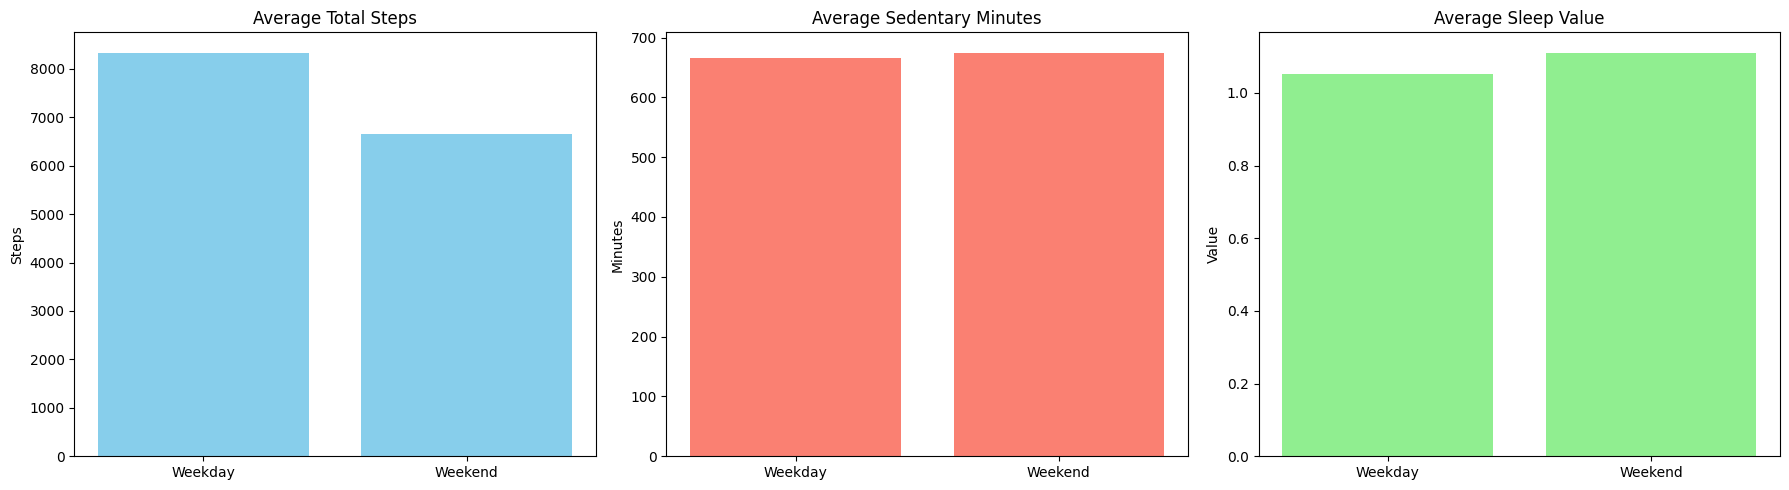

In [ ]:
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total Steps
axes[0].bar(avg_week_part['part_of_week'], avg_week_part['TotalSteps'], color='skyblue')
axes[0].set_title('Average Total Steps')
axes[0].set_ylabel('Steps')

# Sedentary Minutes
axes[1].bar(avg_week_part['part_of_week'], avg_week_part['SedentaryMinutes'], color='salmon')
axes[1].set_title('Average Sedentary Minutes')
axes[1].set_ylabel('Minutes')

# Sleep Value
axes[2].bar(avg_week_part['part_of_week'], avg_week_part['value'], color='lightgreen')
axes[2].set_title('Average Sleep Value')
axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()


In [22]:
summary = merged.groupby('part_of_week').agg({
    'TotalSteps': 'mean',
    'Calories': 'mean',
    'SedentaryMinutes': 'mean'
}).reset_index()

print(summary)


  part_of_week   TotalSteps     Calories  SedentaryMinutes
0      Weekday  8334.491228  2429.140351        665.701754
1      Weekend  6645.055556  2308.833333        674.944444


In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
labels = summary['part_of_week']
steps = summary['TotalSteps']
calories = summary['Calories']
sedentary = summary['SedentaryMinutes']

x = np.arange(len(labels))  # label locations
width = 0.25  # bar width

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, steps, width, label='Steps', color='skyblue')
ax.bar(x, calories, width, label='Calories', color='salmon')
ax.bar(x + width, sedentary, width, label='Sedentary Minutes', color='lightgreen')
# Add this inside your plotting code after ax.bar(...)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Redo bar plots and store them in variables
bars1 = ax.bar(x - width, steps, width, label='Steps', color='skyblue')
bars2 = ax.bar(x, calories, width, label='Calories', color='salmon')
bars3 = ax.bar(x + width, sedentary, width, label='Sedentary Minutes', color='lightgreen')

# Call the label function
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Labels and legend
ax.set_xlabel('Part of Week')
ax.set_ylabel('Average Value')
ax.set_title('Weekday vs Weekend Activity Summary')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

KeyError: 'TotalSteps'

In [24]:
# Add this inside your plotting code after ax.bar(...)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Redo bar plots and store them in variables
bars1 = ax.bar(x - width, steps, width, label='Steps', color='skyblue')
bars2 = ax.bar(x, calories, width, label='Calories', color='salmon')
bars3 = ax.bar(x + width, sedentary, width, label='Sedentary Minutes', color='lightgreen')

# Call the label function
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)


In [27]:
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 21:
        return "Evening"
    else:
        return "Night"

hourly_intensities['ActivityHour'] = pd.to_datetime(hourly_intensities['ActivityHour'],
    format='%m/%d/%Y %I:%M:%S %p')
hourly_intensities['hour'] = hourly_intensities['ActivityHour'].dt.hour
hourly_intensities['time_of_day'] = hourly_intensities['hour'].apply(get_time_of_day)


In [28]:
hourly_intensities['day_of_week'] = hourly_intensities['ActivityHour'].dt.day_name()
hourly_intensities['part_of_week'] = hourly_intensities['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')


In [31]:
summary_df = hourly_intensities.groupby(['part_of_week', 'time_of_day']).agg({
    'TotalIntensity': 'sum',
    'AverageIntensity': ['mean', 'max', 'min']
}).reset_index()

summary.columns = ['part_of_week', 'time_of_day', 'total_intensity', 'avg_intensity', 'max_intensity', 'min_intensity']
display(summary)


,part_of_week,time_of_day,total_intensity,avg_intensity,max_intensity,min_intensity
0,Weekday,Afternoon,64704,0.264703,2.900000,0.0
1,Weekday,Evening,37676,0.309022,3.000000,0.0
2,Weekday,Morning,53496,0.215206,2.883333,0.0
3,Weekday,Night,22440,0.060061,2.750000,0.0
4,Weekend,Afternoon,35907,0.315306,3.000000,0.0
5,Weekend,Evening,14618,0.257813,3.000000,0.0
6,Weekend,Morning,22617,0.197770,3.000000,0.0
7,Weekend,Night,9283,0.054116,3.000000,0.0


In [36]:
print(summary_df.columns.tolist())

['part_of_week_', 'time_of_day_', 'TotalIntensity_sum', 'AverageIntensity_mean', 'AverageIntensity_max', 'AverageIntensity_min']


In [34]:
# Flatten column names
summary_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in summary_df.columns]


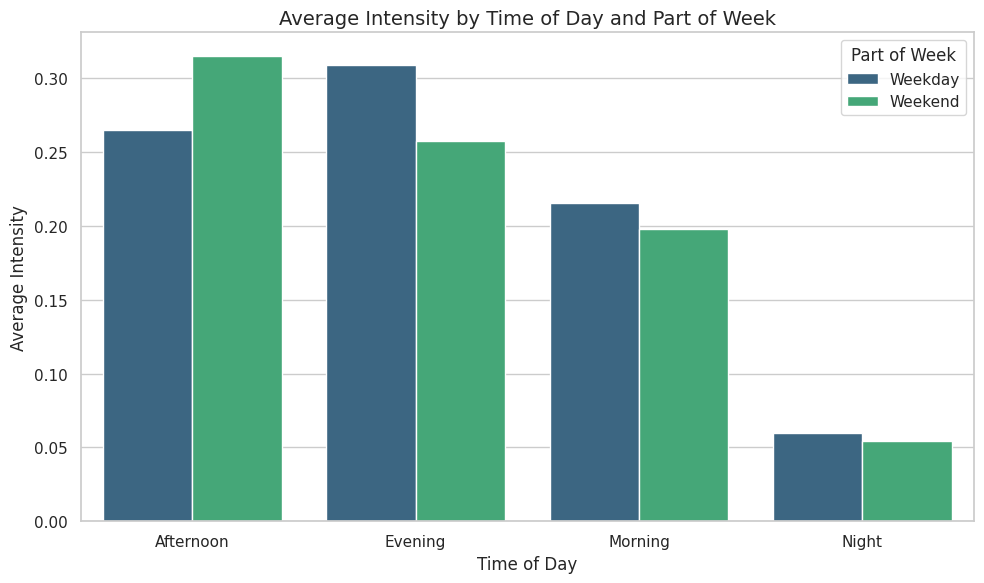

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_df,   # replace with the actual name of your summary table
    x="time_of_day_",
    y="AverageIntensity_mean",
    hue="part_of_week_",
    palette="viridis"
)

# Customize the plot
plt.title("Average Intensity by Time of Day and Part of Week", fontsize=14)
plt.xlabel("Time of Day")
plt.ylabel("Average Intensity")
plt.legend(title="Part of Week")
plt.tight_layout()
plt.show()


In [39]:
# Required libraries
import numpy as np
import pandas as pd

# Define deciles
deciles = [0.1 * i for i in range(1, 10)]  # 0.1 to 0.9

# Function to compute deciles
def compute_deciles(group):
    q = group['TotalIntensity'].quantile(deciles)
    q.index = [f"decile_{int(p*100)}" for p in deciles]
    return q

# Group by part_of_week and time_of_day and compute deciles
decile_summary = hourly_intensities.groupby(['part_of_week', 'time_of_day']).apply(compute_deciles).unstack()

# Reset index for easier plotting later
decile_summary.reset_index(inplace=True)

# Show result
decile_summary.head()


/tmp/ipykernel_26525/3222875110.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decile_summary = hourly_intensities.groupby(['part_of_week', 'time_of_day']).apply(compute_deciles).unstack()


TotalIntensity part_of_week decile_10                       decile_20          \
time_of_day                 Afternoon Evening Morning Night Afternoon Evening   
0                   Weekday       0.0     0.0     0.0   0.0       0.0     0.0   
1                   Weekend       0.0     0.0     0.0   0.0       0.0     0.0   

TotalIntensity               decile_30                       decile_40  \
time_of_day    Morning Night Afternoon Evening Morning Night Afternoon   
0                  0.0   0.0       3.0     2.0     0.0   0.0       6.0   
1                  0.0   0.0       2.0     1.0     0.0   0.0       7.0   

TotalIntensity                       decile_50                        \
time_of_day    Evening Morning Night Afternoon Evening Morning Night   
0                  7.0     1.0   0.0      10.0    11.0     4.0   0.0   
1                  6.0     0.0   0.0      12.0    10.0     1.0   0.0   

TotalIntensity decile_60                       decile_70                  \
time_of_day    Afternoon Evening Morning Night Afternoon Evening Morning   
0                   14.0    15.0     8.0   0.0      18.0    21.0    14.0   
1                   17.0    14.0     5.0   0.0      23.0    17.0    11.5   

TotalIntensity       decile_80                       decile_90          \
time_of_day    Night Afternoon Evening Morning Night Afternoon Evening   
0                1.0      25.0    29.0    22.0   3.0      38.0    46.0   
1                1.0      31.0    24.0    20.0   3.0      43.0    36.0   

TotalIntensity                
time_of_day    Morning Night  
0                 36.0  10.0  
1                 34.5  11.0

In [53]:
# Flatten MultiIndex columns
decile_summary.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in decile_summary.columns]
print(decile_summary.columns.tolist())

['part_of_week_', 'decile_10_Afternoon', 'decile_10_Evening', 'decile_10_Morning', 'decile_10_Night', 'decile_20_Afternoon', 'decile_20_Evening', 'decile_20_Morning', 'decile_20_Night', 'decile_30_Afternoon', 'decile_30_Evening', 'decile_30_Morning', 'decile_30_Night', 'decile_40_Afternoon', 'decile_40_Evening', 'decile_40_Morning', 'decile_40_Night', 'decile_50_Afternoon', 'decile_50_Evening', 'decile_50_Morning', 'decile_50_Night', 'decile_60_Afternoon', 'decile_60_Evening', 'decile_60_Morning', 'decile_60_Night', 'decile_70_Afternoon', 'decile_70_Evening', 'decile_70_Morning', 'decile_70_Night', 'decile_80_Afternoon', 'decile_80_Evening', 'decile_80_Morning', 'decile_80_Night', 'decile_90_Afternoon', 'decile_90_Evening', 'decile_90_Morning', 'decile_90_Night']


In [54]:
# Melt the decile summary into long format
long_deciles = decile_summary.melt(
    id_vars=['part_of_week_'],  # use exact name
    value_vars=[col for col in decile_summary.columns if 'decile' in col],
    var_name='decile_time',
    value_name='intensity'
)

# Extract decile number and time of day from 'decile_time'
long_deciles['decile'] = long_deciles['decile_time'].str.extract(r'decile_(\d+)_')[0].astype(int)
long_deciles['time_of_day'] = long_deciles['decile_time'].str.extract(r'decile_\d+_(\w+)')[0]

# Clean up if needed
long_deciles = long_deciles.drop(columns='decile_time')



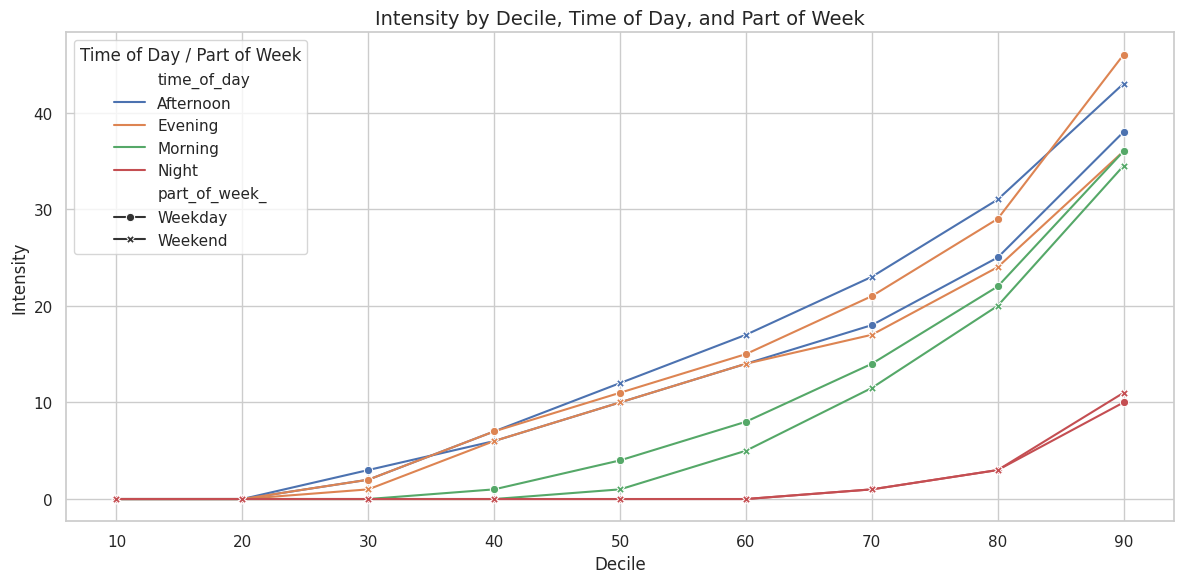

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=long_deciles,
    x="decile",
    y="intensity",
    hue="time_of_day",
    style="part_of_week_",
    markers=True,
    dashes=False
)

plt.title("Intensity by Decile, Time of Day, and Part of Week", fontsize=14)
plt.xlabel("Decile")
plt.ylabel("Intensity")
plt.legend(title="Time of Day / Part of Week")
plt.tight_layout()
plt.show()

The most active users (Decile 90) tend to be especially active in the afternoons and evenings, both on weekdays and weekends, with a slight increase on weekends. Less active users stay inactive regardless of time or day. Nighttime is consistently low in intensity for all users.